In [1]:
%load_ext lab_black

# Local Return Periods

One question of interest is what the return period is for *local* cold extremes.
In other words, how rare was the 2021 cold outbreak at different points?
Understanding local return periods for cold weather can tell us about how surprised buildings and other facilities should have been by the cold they experienced.

We will use two data sets:

1. The GHCND data set: this is station data
1. The ERA5 reanalysis data set: this uses a climate model to assimilate not only temperature data but also other sources of data, and produces a data set that is consistent with the laws of physics.

These data sets can diverge because

1. Point data is different from a grid average
1. The ERA5 data is air temperature at 2m, which is not exactly the same as the surface
1. Potential bias in data sets
1. ERA5 assimilates other sources of data.

Thus, findings that are consistent across the two data sets are relatively likely to be credible

In [2]:
import cartopy.crs as ccrs
from cartopy.feature import STATES, COASTLINE
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import regionmask
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

from codebase.calc import return_period as calc_return_period
from codebase.data import get_ghcn_data, datadir
from codebase.read_ghcn import read_station_metadata
from codebase.fig import smart_save, add_panel_text

## GHCND

We start with the GHCND data

First, load the data set in which we computed the empirical exceedance probability for annual-maximum cold outbreaks of different lengths.
This is just the number of years in which there was a cold outbreak, divided by the number of years in the data set

In [3]:
return_period = pd.read_csv(
    datadir("processed", "ghcnd", "return_periods.csv"),
    index_col="stnid",
    false_values="False",
    true_values="True",
)

Now we join this with station metadata to get lat and lon so we can plot

In [4]:
metadata = read_station_metadata(datadir("raw", "ghcnd_stations.txt"))
mrg = return_period.join(metadata[["LATITUDE", "LONGITUDE", "NAME"]], how="left")
mrg.head()

,temp_1_days,record_1_days,temp_2_days,record_2_days,temp_3_days,record_3_days,temp_4_days,record_4_days,LATITUDE,LONGITUDE,NAME
stnid,,,,,,,,,,,
USC00410586,4.795875,False,6.059259,False,9.947883,False,10.985769,False,29.9142,-94.9908,BAYTOWN
USC00410639,28.693711,False,37.622554,False,70.059592,False,55.587162,False,28.4575,-97.7061,BEEVILLE 5 NE
USC00410902,18.541940,False,67.302394,False,54.148056,False,80.983379,False,29.7986,-98.7353,BOERNE
USC00411128,63.749890,False,40.528141,False,33.056376,False,40.306156,False,33.1908,-102.2681,BROWNFIELD #2
USC00411250,265.287044,False,500.000000,True,500.000000,True,500.000000,True,30.7586,-98.2339,BURNET


Here are all the stations we are using:

In [5]:
mrg["NAME"].values

array(['BAYTOWN', 'BEEVILLE 5 NE', 'BOERNE', 'BROWNFIELD #2', 'BURNET',
       'CARRIZO SPRINGS 3S', 'CHISOS BASIN', 'CORSICANA', 'CROSBYTON',
       'DANEVANG 1 W', 'FLOYDADA', 'FOLLETT', 'GATESVILLE',
       'HALLETTSVILLE 2 N', 'HASKELL', 'LEVELLAND', 'MARSHALL', 'MATADOR',
       'MEMPHIS', 'MT PLEASANT', 'MULESHOE #1', 'PANTHER JUNCTION',
       'PARIS', 'PLAINS', 'PLAINVIEW', 'RAYMONDVILLE', 'ROSCOE',
       'SEMINOLE', 'SHERMAN', 'SNYDER', 'SULPHUR SPRINGS', 'TAHOKA',
       'TULIA', 'WILLS PT', 'COLLEGE STN', 'DALLAS FT WORTH AP',
       'PORT ARTHUR SE TX AP', 'HOUSTON HOBBY AP', 'BROWNSVILLE',
       'SAN ANTONIO INTL AP', 'CORPUS CHRISTI', 'CORPUS CHRISTI NAS',
       'KINGSVILLE NAAS', 'AUSTIN-CAMP MABRY', 'WACO RGNL AP',
       'DALLAS LOVE FLD', 'ABILENE RGNL AP', 'WICHITA FALLS MUNI AP',
       'CHILDRESS MUNI AP', 'MIDLAND ODESSA', 'SAN ANGELO',
       'WINKLER CO AP', 'LUBBOCK', 'EL PASO INTL AP', 'AMARILLO',
       'DALHART MUNI AP', 'LUFKIN ANGELINA CO AP'], dtype=ob

Now we can plot the data

In [6]:
durations_plot = [1, 2, 3, 4]
data_proj = ccrs.PlateCarree()
map_proj = ccrs.LambertConformal()

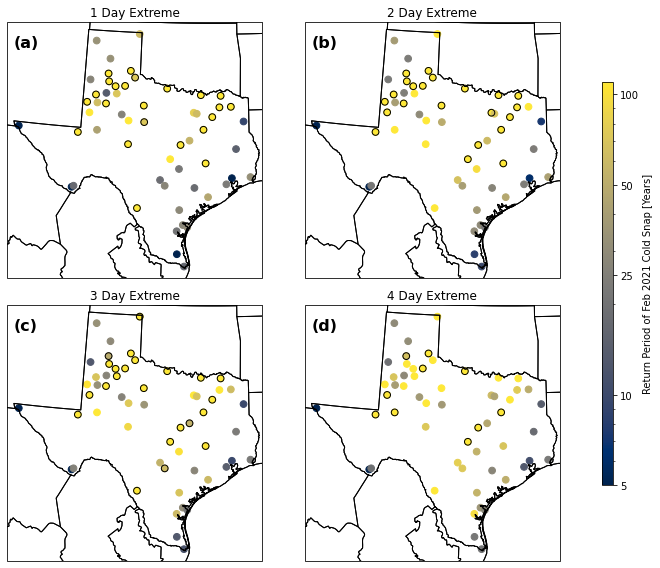

In [7]:
VMAX = 100  # color bar limit
VMIN = 5
TICKS = [VMIN, 10, 25, 50, VMAX]

fig, axes = plt.subplots(
    nrows=2, ncols=2, subplot_kw={"projection": map_proj}, figsize=(10, 8)
)
for ax, dur in zip(axes.flat, durations_plot):
    # scatter plot
    sc = ax.scatter(
        mrg["LONGITUDE"],
        mrg["LATITUDE"],
        c=mrg[f"temp_{dur}_days"],
        norm=colors.LogNorm(VMIN, 1.1 * VMAX),
        transform=data_proj,
        cmap="cividis",
        s=45,
    )
    records = mrg.loc[lambda df: df[f"record_{dur}_days"]]
    ax.scatter(
        records["LONGITUDE"],
        records["LATITUDE"],
        transform=data_proj,
        facecolors="none",
        edgecolors="black",
        s=45,
    )
    ax.set_title(f"{dur} Day Extreme")
    ax.add_feature(STATES)
    ax.add_feature(COASTLINE)

fig.canvas.draw()
fig.tight_layout()

add_panel_text(
    axes,
    xloc=0.025,
    yloc=0.95,
)
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(sc, cax=cax, label="Return Period of Feb 2021 Cold Snap [Years]")
cbar.set_ticks(TICKS)
cbar.ax.set_yticklabels(TICKS)
smart_save("local_rt_ghcnd")
plt.show()

Note that here a circle means it was a record breaking event.
Because I live in Houston and I'm curious, what was the return period at Hobby?

In [8]:
mrg.loc[lambda df: df["NAME"] == "HOUSTON HOBBY AP"]

,temp_1_days,record_1_days,temp_2_days,record_2_days,temp_3_days,record_3_days,temp_4_days,record_4_days,LATITUDE,LONGITUDE,NAME
stnid,,,,,,,,,,,
USW00012918,23.241508,False,24.087269,False,14.591554,False,13.000474,False,29.6381,-95.2819,HOUSTON HOBBY AP


Less than a 1 in 25 year storm at Hobby!
I guess I should prepare for more cold weather here in Houston (admittedly Hobby is near the ocean)

## ERA5

Let's also create the same plot using our (gridded) ERA5 estimates

In [9]:
era5_rt = xr.open_dataarray(
    datadir("processed", "era5", "tx", "return_period.nc")
).rename(
    {"longitude": "lon", "latitude": "lat"}
)  # rename to work w/ regionmask

We want to plot only over land

In [10]:
land = regionmask.defined_regions.natural_earth.land_110
mask = land.mask(era5_rt)
rt_land = era5_rt.where(mask == 0)

These estimates have already been calculated so we can just plot them.
But before we do that, let's bring in some more data.
First, IEA data on power generators

In [11]:
generators = pd.read_excel(
    datadir("raw", "eia", "november_generator2020.xlsx"),
    skiprows=2,
    sheet_name="Operating",
    index_col="Entity ID",
)
generators.head(5)

,Entity Name,Plant ID,Plant Name,Sector,Plant State,Generator ID,Unit Code,Nameplate Capacity (MW),Net Summer Capacity (MW),Net Winter Capacity (MW),...,Planned Derate of Summer Capacity (MW),Planned Uprate Year,Planned Uprate Month,Planned Uprate of Summer Capacity (MW),County,Latitude,Longitude,Google Map,Bing Map,Balancing Authority Code
Entity ID,,,,,,,,,,,,,,,,,,,,,
63560,"TDX Sand Point Generating, LLC",1.0,Sand Point,IPP Non-CHP,AK,1,NaN,0.9,0.4,0.4,...,,,,,Aleutians East,55.339722,-160.4972,Map,Map,NaN
63560,"TDX Sand Point Generating, LLC",1.0,Sand Point,IPP Non-CHP,AK,2,NaN,0.9,0.3,0.3,...,,,,,Aleutians East,55.339722,-160.4972,Map,Map,NaN
63560,"TDX Sand Point Generating, LLC",1.0,Sand Point,IPP Non-CHP,AK,3,NaN,0.5,0.3,0.3,...,,,,,Aleutians East,55.339722,-160.4972,Map,Map,NaN
63560,"TDX Sand Point Generating, LLC",1.0,Sand Point,IPP Non-CHP,AK,5,NaN,0.7,0.4,0.3,...,,,,,Aleutians East,55.339722,-160.4972,Map,Map,NaN
63560,"TDX Sand Point Generating, LLC",1.0,Sand Point,IPP Non-CHP,AK,WT1,NaN,0.5,0.1,0.1,...,,,,,Aleutians East,55.339722,-160.4972,Map,Map,NaN


Some recoding necessary

In [12]:
tx_generators = (
    generators.loc[
        lambda df: df["Plant State"] == "TX",
        ["Net Winter Capacity (MW)", "Technology", "Latitude", "Longitude"],
    ]
    .assign(
        **{
            "Net Winter Capacity (MW)": lambda df: pd.to_numeric(
                df["Net Winter Capacity (MW)"]
            )
        }
    )
    .rename(columns={"Net Winter Capacity (MW)": "Winter Capacity (MW)"})
    .loc[lambda df: df["Winter Capacity (MW)"] > 25]
    .dropna()
)
TECH_KEYS = {
    "Natural Gas Fired Combustion Turbine": "Natural Gas",
    "Conventional Steam Coal": "Other Thermal",
    "Natural Gas Fired Combined Cycle": "Natural Gas",
    "Natural Gas Steam Turbine": "Natural Gas",
    "Conventional Hydroelectric": "Other",
    "Nuclear": "Nuclear",
    "Other Gases": "Natural Gas",
    "Wood/Wood Waste Biomass": "Other Thermal",
    "All Other": "Other",
    "Petroleum Coke": "Other Thermal",
    "Onshore Wind Turbine": "Wind",
    "Batteries": "Other",
    "Solar Photovoltaic": "Solar",
    "Natural Gas Internal Combustion Engine": "Natural Gas",
    "Petroleum Liquids": "Other Thermal",
    "Landfill Gas": "Other Thermal",
    "Other Waste Biomass": "Other Thermal",
    "Flywheels": "Other",
}
tx_generators["Technology"] = tx_generators["Technology"].replace(TECH_KEYS)
tx_generators = tx_generators.loc[
    lambda df: df["Technology"].isin(
        ["Natural Gas", "Other Thermal", "Nuclear", "Wind", "Solar"]
    )
]

Now also population data

In [13]:
pop = (
    xr.open_dataarray(
        datadir(
            "raw",
            "gpwv4",
            "gpw_v4_population_density_rev11_2pt5_min.nc",
        )
    )
    .sel(raster=5)
    .rename({"longitude": "lon", "latitude": "lat"})
)

In [14]:
states = regionmask.defined_regions.natural_earth.us_states_50
mask = states.mask(pop)
tx_idx = states.map_keys("Texas")
pop_tx = pop.where(mask == tx_idx, drop=True)

And finally the outline of the Texas interconnect

In [15]:
ercot = gp.read_file(
    datadir("raw", "eia", "regions_NERC", "NercRegions_201907.shp")
).loc[lambda df: df["NERC"] == "TRE"]

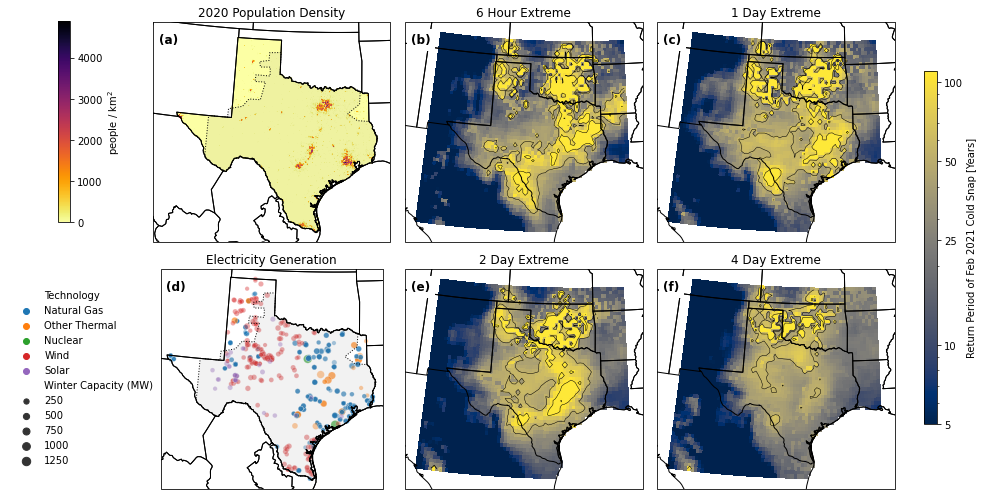

In [16]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=3,
    subplot_kw={"projection": map_proj},
    figsize=(14, 7),
)

for ax, dur, dur_name in zip(
    axes.flat[[1, 2, 4, 5]], [6, 24, 48, 96], ["6 Hour", "1 Day", "2 Day", "4 Day"]
):
    rt_land.sel(duration=dur).plot(
        ax=ax,
        norm=colors.LogNorm(VMIN, VMAX),
        transform=data_proj,
        cmap="cividis",
        add_colorbar=False,
    )
    rt_land.sel(duration=dur).plot.contour(
        ax=ax,
        transform=data_proj,
        add_colorbar=False,
        levels=[50, 100],
        colors="k",
        linewidths=0.5,
    )
    ax.set_title(f"{dur_name} Extreme")


# Population Density
ax = axes.flat[0]
C0 = pop_tx.plot(ax=ax, transform=data_proj, add_colorbar=False, cmap="inferno_r")
ax.set_title("2020 Population Density")

# Generation Capacity
ax = axes.flat[3]
scp = sns.scatterplot(
    x="Longitude",
    y="Latitude",
    size="Winter Capacity (MW)",
    hue="Technology",
    data=tx_generators,
    transform=data_proj,
    ax=ax,
    alpha=0.4,
)
ax.set_title("Electricity Generation")
handles, labels = ax.get_legend_handles_labels()
ax.legend_.remove()

# add ercot to population and generation
for ax in axes.flat[[0, 3]]:
    ax.add_geometries(
        ercot["geometry"],
        crs=data_proj,
        edgecolor="black",
        facecolor="none",
        linestyle=":",
    )
    ax.add_geometries(
        ercot["geometry"],
        crs=data_proj,
        edgecolor="none",
        facecolor="gray",
        alpha=0.1,
    )

# add boundaries to every figure
for ax in axes.flat:
    ax.add_feature(STATES)
    ax.add_feature(COASTLINE)

# tighten the layout
fig.canvas.draw()
fig.tight_layout()

# now we can add axes for our colorbars


# COLORBAR for local return periods
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.91, 0.15, 0.0125, 0.7])
cbar = fig.colorbar(sc, cax=cax, label="Return Period of Feb 2021 Cold Snap [Years]")
cbar.set_ticks(TICKS)
cbar.ax.set_yticklabels(TICKS)

# colorbar for population density
fig.subplots_adjust(left=0.125)
popcbax = fig.add_axes([0.05, 0.55, 0.0125, 0.4])
fig.colorbar(C0, cax=popcbax, label="people / km$^2$")

# colorbar for generation capacity
gencbax = fig.add_axes([0.0, 0.05, 0.1, 0.5])
gencbax.axis("off")
gencbax.legend(
    handles,
    labels,
    ncol=1,
    loc="lower left",
    frameon=False,
)

# add (a), (b), etc
add_panel_text(
    axes,
    xloc=0.025,
    yloc=0.95,
    backgroundcolor="white",
    fontsize=12,
)

# finally done!
smart_save("local_rt_era5")
plt.show()

We can see that our findings are generally consistent across these two very different datasets, which adds credibility.